# Image Similarity Searching and Ranking

In [1]:
%matplotlib inline

import os
from pathlib import Path
import random
import argparse
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image

### Tensorflow GPU Setup

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Load the latest saved model file
- [x] __If you can't see the model file or directory, enter "python cnn_train.py" on the console, please.__
```python
    python cnn_train.py
    python cnn_train.py --epochs=xx
```

In [3]:
saved_model_files = []
model_path = Path('./models')
for filename in os.listdir(model_path):
    if os.path.getsize(model_path/filename) > 0 and filename.lower().endswith('.h5'):
        saved_model_files.append(filename)

model_file = model_path/saved_model_files[-1]
model_file.name

'model-1574005294.h5'

In [4]:
reloaded_model = tf.keras.models.load_model(model_file)
reloaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

## Autoencoder Model
<br><br>
<img src="docs/autoencoder_concept.png" width=60% align=left>

__Find out the dense layer's name which has features information on the model summary table.__

In [5]:
layer_name = 'dense_1'
layer_name

'dense_1'

In [6]:
dataset_path = Path('./dataset/train')
labels = ['andesite', 'gneiss', 'marble', 'quartzite', 'rhyolite', 'schist']

valid_data_generator = image.ImageDataGenerator(rescale=1./255)
similarity_generator = valid_data_generator.flow_from_directory(
    dataset_path,
    target_size=(28, 28),
    batch_size=1,
    shuffle=False,
    classes=labels,
    class_mode="sparse")

Found 26986 images belonging to 6 classes.


In [7]:
intermediate_layer_model = tf.keras.models.Model(
    inputs=reloaded_model.input,
    outputs=reloaded_model.get_layer(layer_name).output)

intermediate_output = intermediate_layer_model.predict_generator(generator=similarity_generator)

In [8]:
intermediate_output.shape

(26986, 6)

## Cosine Similarity
<br><br>
![](docs/cosine_similarity.png)

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

In [10]:
# base similarity matrix (all dot products)
# replace this with A.dot(A.T).toarray() for sparse representation
similarity = np.dot(intermediate_output, intermediate_output.T)

# squared magnitude of preference vectors (number of occurrences)
square_mag = np.diag(similarity)

# inverse squared magnitude
inv_square_mag = 1 / square_mag

# if it doesn't occur, set it's inverse magnitude to zero (instead of inf)
inv_square_mag[np.isinf(inv_square_mag)] = 0

# inverse of the magnitude
inv_mag = np.sqrt(inv_square_mag)

# cosine similarity (elementwise multiply by inverse magnitudes)
cosine = similarity * inv_mag
cosine = cosine.T * inv_mag

## Searching Image Similarity

In [11]:
top_raking = 5

### Query image input
- Default is random. You can input specific image that you want.

In [20]:
input_idx = np.random.randint(len(similarity_generator.filenames))

dataset\train\andesite\PKDBB.jpg


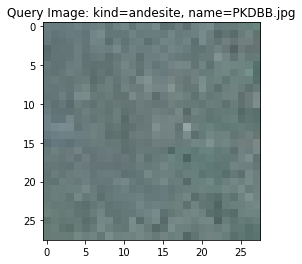

In [21]:
similarity = np.argsort(cosine[input_idx])[::-1][:top_raking]
file_path = dataset_path / similarity_generator.filenames[input_idx]
print(file_path)
img = image.load_img(file_path, target_size=(28, 28))
plt.title(f"Query Image: kind={file_path.parent.stem}, name={file_path.name}")
plt.imshow(img)
plt.show()

### Top similar images

In [22]:
similarity

array([3008, 3952, 4220, 1422, 1421], dtype=int64)

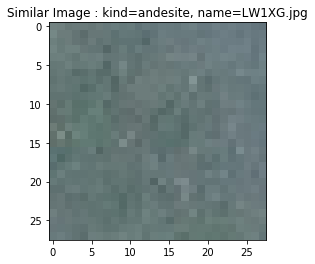

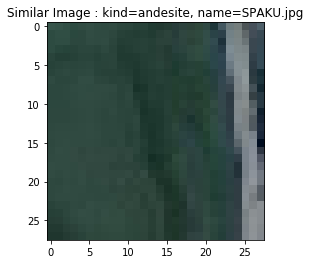

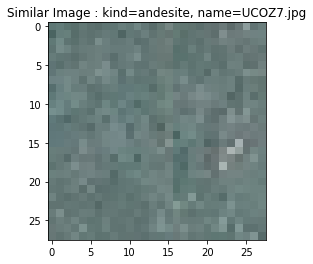

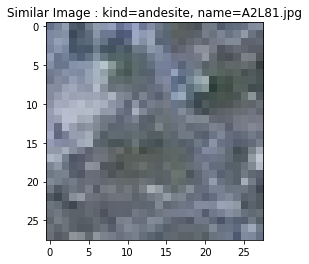

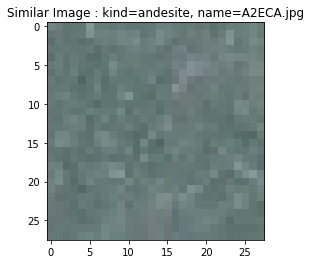

In [23]:
for idx in similarity:
    file_path = dataset_path / similarity_generator.filenames[idx]
    img = image.load_img(file_path, target_size=(28, 28))
    plt.imshow(img)
    plt.title(f"Similar Image : kind={file_path.parent.stem}, name={file_path.name}")
    plt.show()

---
# Thank you!
<img src="https://media.licdn.com/dms/image/C5103AQE834J0PWkG5g/profile-displayphoto-shrink_200_200/0?e=1579132800&v=beta&t=Vc3geyDnIDnn1HiFVT26-VP-qqyJZH_BGfZPtcJpk9U" align=left>